In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import statsmodels.api as sm
from  statsmodels.stats.outliers_influence import variance_inflation_factor

### Step 1 : Read and Understand the data

In [2]:
df = pd.read_csv('day.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
df.shape

(730, 16)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [5]:
#There are no missing values in the dataset.

### Step 2 : Data Preparation

- You can observe in the dataset that some of the variables like 'weathersit' and 'season' have values as 1, 2, 3, 4 which have specific labels associated with them (as can be seen in the data dictionary). These numeric values associated with the labels may indicate that there is some order to them - which is actually not the case (Check the data dictionary and think why). So, it is advisable to convert such feature values into categorical string values before proceeding with model building. Please refer the data dictionary to get a better understanding of all the independent variables.
- You might notice the column 'yr' with two values 0 and 1 indicating the years 2018 and 2019 respectively. At the first instinct, you might think it is a good idea to drop this column as it only has two values so it might not be a value-add to the model. But in reality, since these bike-sharing systems are slowly gaining popularity, the demand for these bikes is increasing every year proving that the column 'yr' might be a good variable for prediction. So think twice before dropping it. 

In [6]:
#1:spring, 2:summer, 3:fall, 4:winter
def season(x):
    if x==1:
        return 'spring'
    elif x==2:
        return 'summer'
    elif x==3:
        return 'fall'
    else:
        return 'winter'

In [7]:
df.season = df.season.apply(season)

In [8]:
df.season.value_counts()

fall      188
summer    184
spring    180
winter    178
Name: season, dtype: int64

In [9]:
# Month column
def month_col(x):
    if x == 1:
        return 'Jan'
    elif x == 2:
        return 'Feb'
    elif x == 3:
        return 'Mar'
    elif x == 4:
        return 'Apr'
    elif x == 5:
        return 'May'
    elif x == 6:
        return 'Jun'
    elif x == 7:
        return 'Jul'
    elif x == 8:
        return 'Aug'
    elif x == 9:
        return 'Sep'
    elif x == 10:
        return 'Oct'
    elif x == 11:
        return 'Nov'
    elif x == 12:
        return 'Dec'

In [10]:
df.mnth = df.mnth.apply(month_col)

In [11]:
df.mnth.value_counts()

Jan    62
Mar    62
May    62
Jul    62
Aug    62
Oct    62
Dec    62
Apr    60
Jun    60
Sep    60
Nov    60
Feb    56
Name: mnth, dtype: int64

In [12]:
# Checking  the workinf day column -- -- if day is neither weekend nor holiday is 1, otherwise is 0.
df.workingday.value_counts()

1    504
0    226
Name: workingday, dtype: int64

In [13]:
def is_workday(x):
    if x== 0:
        return 'no'
    else:
        return 'yes'

In [14]:
df.workingday = df.workingday.apply(is_workday)
df.workingday.value_counts()

yes    504
no     226
Name: workingday, dtype: int64

In [15]:
# Checking  the year column -- (0: 2018, 1:2019).
df.yr.value_counts()

0    365
1    365
Name: yr, dtype: int64

In [16]:
def assgn_year(x):
    if x== 0:
        return '2018'
    else:
        return '2019'

In [17]:
df.yr = df.yr.apply(assgn_year)
df.yr.value_counts()

2018    365
2019    365
Name: yr, dtype: int64

In [18]:
# Holiday columm - weather day is a holiday or not
df.holiday.value_counts(normalize = True)

0    0.971233
1    0.028767
Name: holiday, dtype: float64

In [19]:
def holidays(x):
    if x == 0:
        return 'not holiday'
    else:
        return 'holiday'

In [20]:
df.holiday = df.holiday.apply(holidays)
df.holiday.value_counts(normalize = True)

not holiday    0.971233
holiday        0.028767
Name: holiday, dtype: float64

In [21]:
# Checking weather column - 
#  weathersit : 
# 		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
# 		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
# 		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
# 		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

df.weathersit.value_counts(normalize= True)

1    0.634247
2    0.336986
3    0.028767
Name: weathersit, dtype: float64

In [22]:
# Assigning the given values to the numbers.

def weather(x):
    if x == 1:
        return 'Clear weather'
    elif x == 2:
        return 'Partly cloudy weather'
    elif x == 3:
        return 'Cloudy weather with rains'
    else:
        return 'Extreme weather'

In [23]:
df.weathersit = df.weathersit.apply(weather)
df.weathersit.value_counts(normalize = True)

Clear weather                0.634247
Partly cloudy weather        0.336986
Cloudy weather with rains    0.028767
Name: weathersit, dtype: float64

In [24]:
# Checking Weekday column
df.weekday.value_counts()

1    105
2    105
3    104
4    104
5    104
6    104
0    104
Name: weekday, dtype: int64

In [25]:
def day_of_week(x):
    if x == 1:
        return 'Monday'
    elif x== 2:
        return 'Tuesday'
    elif x == 3:
        return "Wednesday"
    elif x == 4:
        return "Thursday"
    elif x == 5:
        return 'Friday'
    elif x == 6:
        return 'Saturday'
    else:
        return 'Sunday'

In [26]:
df.weekday = df.weekday.apply(day_of_week)
df.weekday.value_counts()

Monday       105
Tuesday      105
Wednesday    104
Thursday     104
Friday       104
Saturday     104
Sunday       104
Name: weekday, dtype: int64

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    object 
 3   yr          730 non-null    object 
 4   mnth        730 non-null    object 
 5   holiday     730 non-null    object 
 6   weekday     730 non-null    object 
 7   workingday  730 non-null    object 
 8   weathersit  730 non-null    object 
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(4), object(8)
memory usage: 91.4+ KB


In [28]:
# Changing the dtypes of dteday colum
df.dteday = df.dteday.astype('datetime64')

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     730 non-null    int64         
 1   dteday      730 non-null    datetime64[ns]
 2   season      730 non-null    object        
 3   yr          730 non-null    object        
 4   mnth        730 non-null    object        
 5   holiday     730 non-null    object        
 6   weekday     730 non-null    object        
 7   workingday  730 non-null    object        
 8   weathersit  730 non-null    object        
 9   temp        730 non-null    float64       
 10  atemp       730 non-null    float64       
 11  hum         730 non-null    float64       
 12  windspeed   730 non-null    float64       
 13  casual      730 non-null    int64         
 14  registered  730 non-null    int64         
 15  cnt         730 non-null    int64         
dtypes: datetime64[ns](1), floa

#### EDA

In [30]:
cat_df = df.select_dtypes(include=['object'])
cat_df.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit'],
      dtype='object')

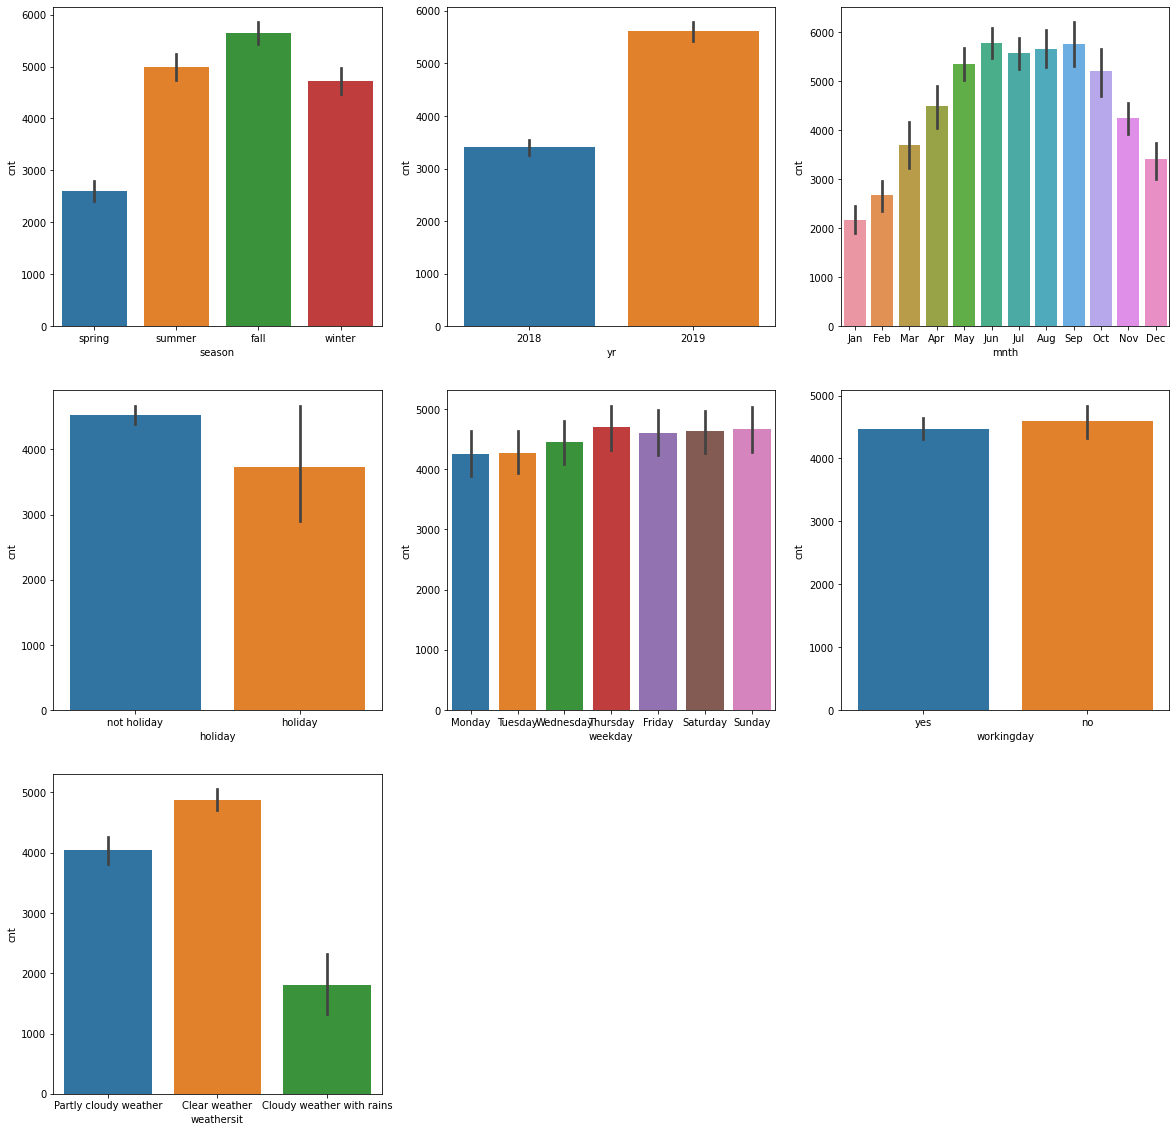

In [31]:
plt.figure(figsize=(20,20))
for i in range(len(cat_df.columns)):
    plt.subplot(3,3,i+1)
    sns.barplot(data=df, x=cat_df.columns[i] , y='cnt')

- Fall season has highest counts of rentals followed by summer 
- Count of rentals in 2019 was higher than 2018
- Count of rental increased between months May to October
- Higher bike rentals observed on clear weather whereas significant drop is observed in rainy weathers.

In [32]:
# 'dteday' and 'instant'  column will not help in model building
# ALso cnt column is sum of casual+ registered . so dropping 'casual' and 'registered'

In [33]:
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [34]:
df = df.drop(['instant', 'dteday','casual', 'registered'], axis =1)

In [35]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,2018,Jan,not holiday,Monday,yes,Partly cloudy weather,14.110847,18.18125,80.5833,10.749882,985
1,spring,2018,Jan,not holiday,Tuesday,yes,Partly cloudy weather,14.902598,17.68695,69.6087,16.652113,801
2,spring,2018,Jan,not holiday,Wednesday,yes,Clear weather,8.050924,9.47025,43.7273,16.636703,1349
3,spring,2018,Jan,not holiday,Thursday,yes,Clear weather,8.200000,10.60610,59.0435,10.739832,1562
4,spring,2018,Jan,not holiday,Friday,yes,Clear weather,9.305237,11.46350,43.6957,12.522300,1600


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    object 
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    object 
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    object 
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(1), object(7)
memory usage: 68.6+ KB


In [37]:
num_df = df.select_dtypes(exclude='object')
num_df.columns

Index(['temp', 'atemp', 'hum', 'windspeed', 'cnt'], dtype='object')

<AxesSubplot:>

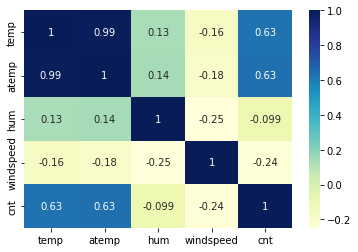

In [38]:
sns.heatmap(num_df.corr(), cmap='YlGnBu', annot=True)

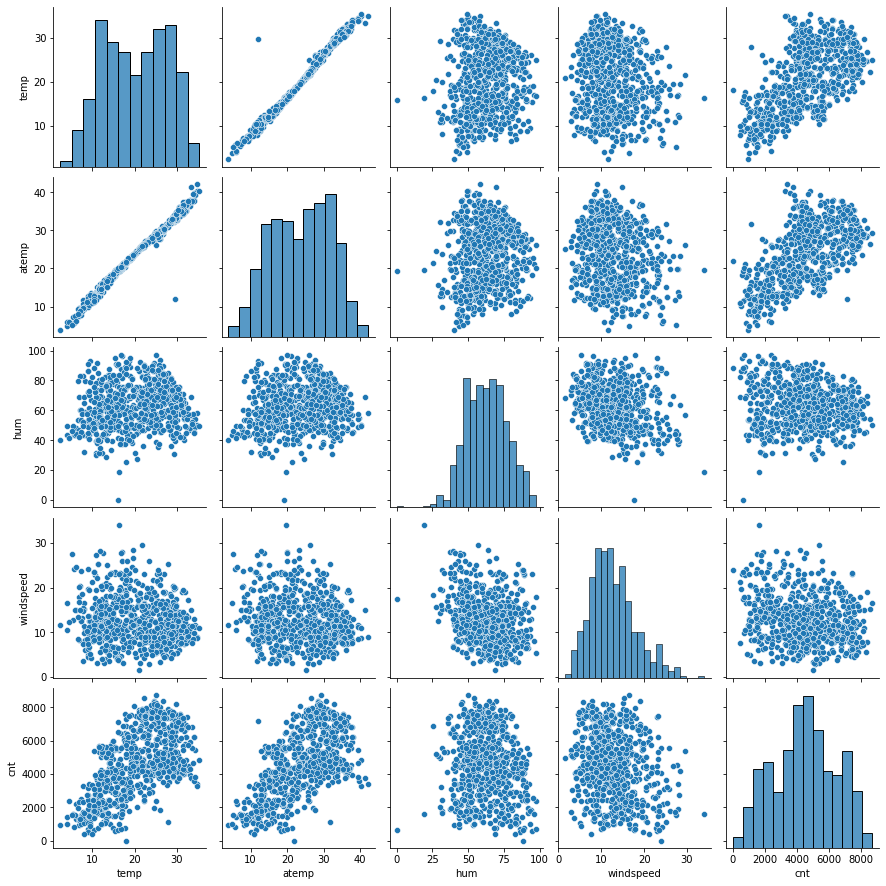

In [39]:
sns.pairplot(num_df)

In [40]:
# 'temp' and 'atemp' have similar correlation and show similar distribution . Hence we will keep only one.
df = df.drop('atemp', axis=1)
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,spring,2018,Jan,not holiday,Monday,yes,Partly cloudy weather,14.110847,80.5833,10.749882,985
1,spring,2018,Jan,not holiday,Tuesday,yes,Partly cloudy weather,14.902598,69.6087,16.652113,801
2,spring,2018,Jan,not holiday,Wednesday,yes,Clear weather,8.050924,43.7273,16.636703,1349
3,spring,2018,Jan,not holiday,Thursday,yes,Clear weather,8.200000,59.0435,10.739832,1562
4,spring,2018,Jan,not holiday,Friday,yes,Clear weather,9.305237,43.6957,12.522300,1600


In [41]:
df.shape

(730, 11)

In [42]:
df_dummy = pd.get_dummies(cat_df, drop_first=True)
df_dummy.head()

,season_spring,season_summer,season_winter,yr_2019,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,mnth_Jul,mnth_Jun,...,holiday_not holiday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,workingday_yes,weathersit_Cloudy weather with rains,weathersit_Partly cloudy weather
0,1,0,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,1,0,1
1,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,1,0,1,0,1
2,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,1,0,0
3,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0
4,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0


In [43]:
df_new = pd.concat([df, df_dummy], axis=1 )

In [44]:
df_new.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,...,holiday_not holiday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,workingday_yes,weathersit_Cloudy weather with rains,weathersit_Partly cloudy weather
0,spring,2018,Jan,not holiday,Monday,yes,Partly cloudy weather,14.110847,80.5833,10.749882,...,1,1,0,0,0,0,0,1,0,1
1,spring,2018,Jan,not holiday,Tuesday,yes,Partly cloudy weather,14.902598,69.6087,16.652113,...,1,0,0,0,0,1,0,1,0,1
2,spring,2018,Jan,not holiday,Wednesday,yes,Clear weather,8.050924,43.7273,16.636703,...,1,0,0,0,0,0,1,1,0,0
3,spring,2018,Jan,not holiday,Thursday,yes,Clear weather,8.200000,59.0435,10.739832,...,1,0,0,0,1,0,0,1,0,0
4,spring,2018,Jan,not holiday,Friday,yes,Clear weather,9.305237,43.6957,12.522300,...,1,0,0,0,0,0,0,1,0,0


In [45]:
df_new = df_new.drop(cat_df, axis=1)

In [46]:
df_new.shape

(730, 29)

#### Splitting into train- test-split

In [47]:
df_train, df_test = train_test_split(df_new , train_size=0.7, random_state=100)

In [48]:
print(df_train.shape)
print(df_test.shape)

(510, 29)
(220, 29)


#### Rescaling

In [49]:
num_var = df_new.select_dtypes(include=['float64','int64']).columns
num_var

Index(['temp', 'hum', 'windspeed', 'cnt'], dtype='object')

In [50]:
scaler = MinMaxScaler()

In [51]:
df_train[num_var].head()

,temp,hum,windspeed,cnt
576,29.246653,70.4167,11.083475,7216
426,16.980847,62.1250,10.792293,4066
728,10.489153,48.3333,23.500518,1796
482,15.443347,48.9583,8.708325,4220
111,13.803347,72.9583,14.707907,1683


In [52]:
df_train[num_var] = scaler.fit_transform(df_train[num_var])
df_train.head()

,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter,yr_2019,mnth_Aug,mnth_Dec,...,holiday_not holiday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,workingday_yes,weathersit_Cloudy weather with rains,weathersit_Partly cloudy weather
576,0.815169,0.725633,0.264686,0.827658,0,0,0,1,0,0,...,1,0,0,0,0,0,1,1,0,0
426,0.442393,0.640189,0.255342,0.465255,1,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
728,0.245101,0.498067,0.663106,0.204096,1,0,0,1,0,1,...,1,1,0,0,0,0,0,1,0,0
482,0.395666,0.504508,0.188475,0.482973,0,1,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
111,0.345824,0.751824,0.380981,0.191095,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1


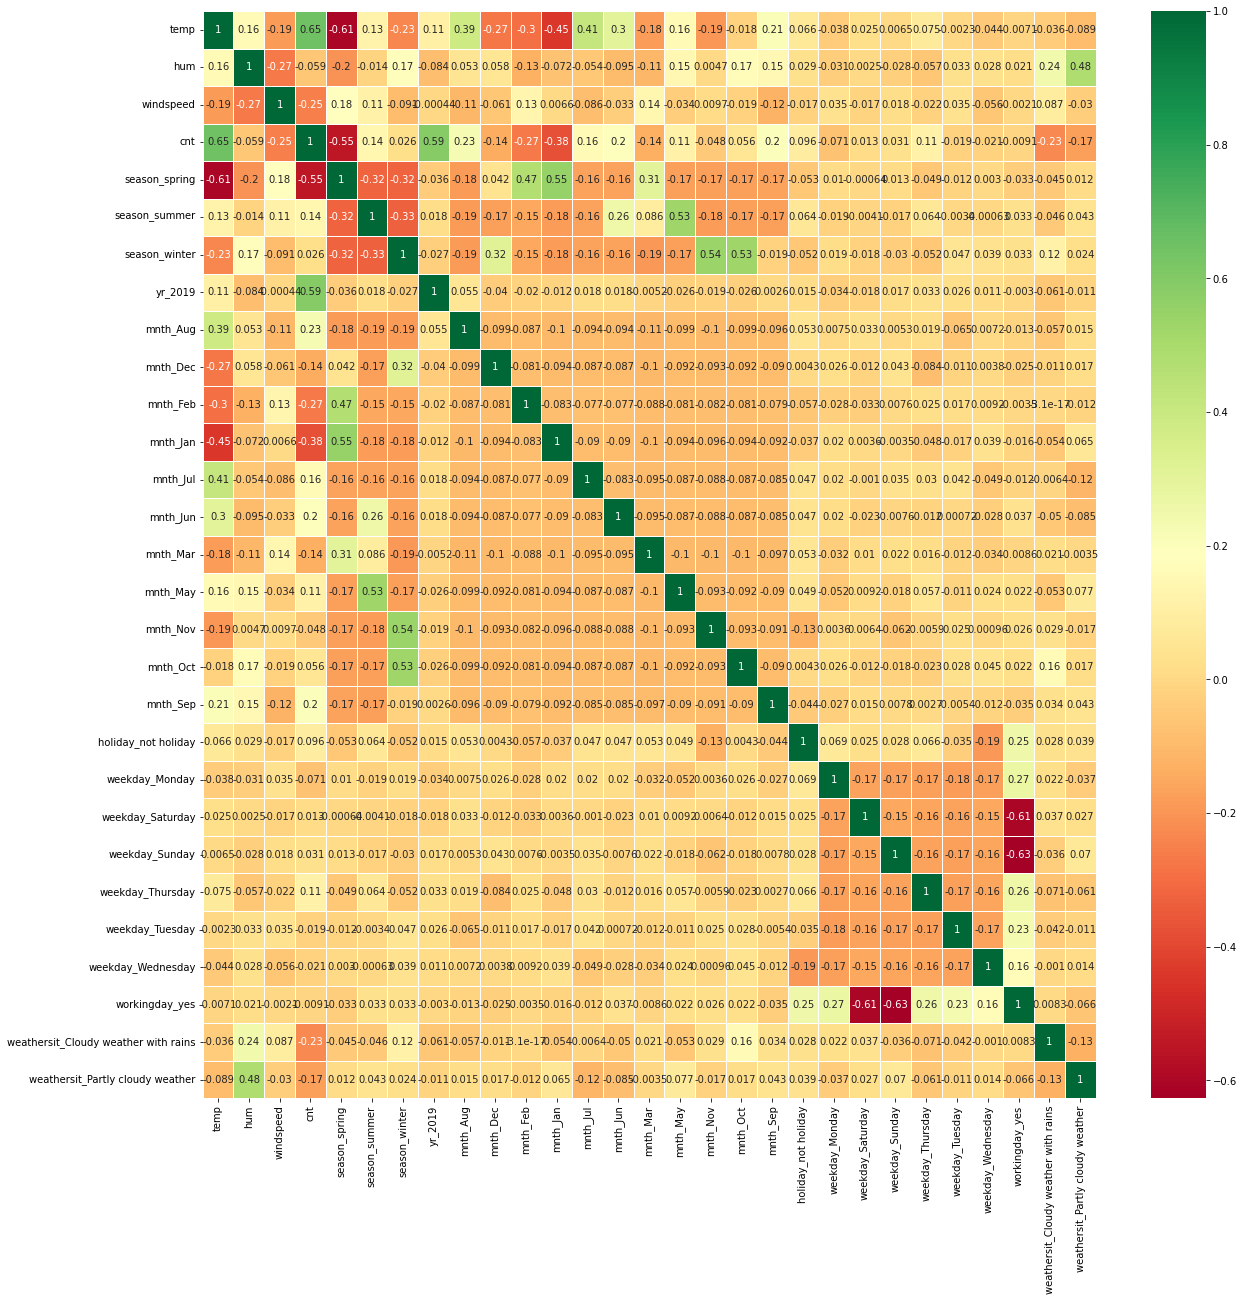

In [53]:
plt.figure(figsize=(20,20))
sns.heatmap(df_train.corr(), annot=True, cmap= 'RdYlGn', linewidth=1)
plt.show()

### Step 3: Training the Model

In [54]:
#X_train, y_train
y_train = df_train.pop('cnt')
X_train = df_train

##### Lets use Backward approach.

For dropping variables
- High p, high vif (remove first, insignificant)
- high low
  - high p , low vif (remove these first, vif changes when variables are removed and may get decreased)
  - low p, high vif (remove after above ones)
-  low p , low vif (significant) 

In [55]:
# add constant
X_train_sm = sm.add_constant(X_train)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# check summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     97.49
Date:                Sun, 05 Jun 2022   Prob (F-statistic):          1.34e-178
Time:                        19:58:02   Log-Likelihood:                 522.99
No. Observations:                 510   AIC:                            -988.0
Df Residuals:                     481   BIC:                            -865.2
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    0.2564      0.054      4.741      0.000       0.150       0.363
temp                                     0.4405      0.047      9.412      0.000       0.349       0.532
hum                                     -0.1574      0.039     -4.043      0.000      -0.234      -0.081
windspeed                               -0.1825      0.026     -7.003      0.000      -0.234      -0.131
season_spring                           -0.0404      0.030     -1.335      0.182      -0.100       0.019
season_summer                            0.0464      0.026      1.761      0.079      -0.005       0.098
season_winter                            0.1126      0.028      3.994      0.000       0.057       0.168
yr_2019                                  0.2311      0.008     28.384      0.000       0.215       0.247
mnth_Aug                                 0.0273      0.034      0.806      0.421      -0.039       0.094
mnth_Dec                                -0.0444      0.034     -1.309      0.191      -0.111       0.022
mnth_Feb                                -0.0374      0.033     -1.123      0.262      -0.103       0.028
mnth_Jan                                -0.0642      0.034     -1.894      0.059      -0.131       0.002
mnth_Jul                                -0.0285      0.035     -0.808      0.420      -0.098       0.041
mnth_Jun                                 0.0084      0.025      0.336      0.737      -0.041       0.058
mnth_Mar                                 0.0008      0.025      0.032      0.974      -0.048       0.050
mnth_May                                 0.0247      0.021      1.164      0.245      -0.017       0.066
mnth_Nov                                -0.0396      0.037     -1.077      0.282      -0.112       0.033
mnth_Oct                                 0.0056      0.036      0.156      0.876      -0.066       0.077
mnth_Sep                                 0.0908      0.032      2.822      0.005       0.028       0.154
holiday_not holiday                      0.1348      0.065      2.059      0.040       0.006       0.263
weekday_Monday                          -0.0246      0.015     -1.687      0.092      -0.053       0.004
weekday_Saturday                        -0.0557      0.072     -0.777      0.437      -0.197       0.085
weekday_Sunday                          -0.0495      0.072     -0.691      0.490      -0.190       0.091
weekday_Thursday                         0.0042      0.015      0.282      0.778      -0.025       0.034
weekday_Tuesday                         -0.0261      0.015     -1.774      0.077      -0.055       0.003
weekday_Wednesday                       -0.0102      0.015     -0.669      0.504      -0.040       0.020
workingday_yes                        

In [56]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF' ,ascending=False)
vif

,Features,VIF
18,holiday_not holiday,266.66
25,workingday_yes,217.93
21,weekday_Sunday,41.94
20,weekday_Saturday,39.73
1,hum,39.39
0,temp,38.65
3,season_spring,12.50
5,season_winter,12.16
4,season_summer,8.16
16,mnth_Oct,6.43


In [57]:
# Dropping mnth_Mar as it has high p value
X_train_new = X_train.drop('mnth_Mar', axis=1)

In [58]:
# add constant
X_train_sm = sm.add_constant(X_train_new)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# check summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     101.3
Date:                Sun, 05 Jun 2022   Prob (F-statistic):          1.32e-179
Time:                        19:58:02   Log-Likelihood:                 522.99
No. Observations:                 510   AIC:                            -990.0
Df Residuals:                     482   BIC:                            -871.4
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    0.2569      0.052      4.968      0.000       0.155       0.359
temp                                     0.4403      0.046      9.550      0.000       0.350       0.531
hum                                     -0.1573      0.039     -4.057      0.000      -0.233      -0.081
windspeed                               -0.1825      0.026     -7.020      0.000      -0.234      -0.131
season_spring                           -0.0401      0.029     -1.401      0.162      -0.096       0.016
season_summer                            0.0463      0.026      1.790      0.074      -0.005       0.097
season_winter                            0.1128      0.028      4.075      0.000       0.058       0.167
yr_2019                                  0.2311      0.008     28.414      0.000       0.215       0.247
mnth_Aug                                 0.0269      0.032      0.843      0.399      -0.036       0.090
mnth_Dec                                -0.0451      0.026     -1.718      0.086      -0.097       0.006
mnth_Feb                                -0.0382      0.022     -1.699      0.090      -0.082       0.006
mnth_Jan                                -0.0650      0.023     -2.883      0.004      -0.109      -0.021
mnth_Jul                                -0.0288      0.034     -0.858      0.391      -0.095       0.037
mnth_Jun                                 0.0081      0.024      0.344      0.731      -0.038       0.055
mnth_May                                 0.0245      0.020      1.233      0.218      -0.015       0.064
mnth_Nov                                -0.0402      0.031     -1.293      0.197      -0.101       0.021
mnth_Oct                                 0.0050      0.031      0.162      0.871      -0.056       0.066
mnth_Sep                                 0.0904      0.029      3.092      0.002       0.033       0.148
holiday_not holiday                      0.1348      0.065      2.061      0.040       0.006       0.263
weekday_Monday                          -0.0246      0.015     -1.692      0.091      -0.053       0.004
weekday_Saturday                        -0.0557      0.072     -0.778      0.437      -0.196       0.085
weekday_Sunday                          -0.0494      0.072     -0.691      0.490      -0.190       0.091
weekday_Thursday                         0.0042      0.015      0.283      0.778      -0.025       0.034
weekday_Tuesday                         -0.0261      0.015     -1.778      0.076      -0.055       0.003
weekday_Wednesday                       -0.0102      0.015     -0.671      0.503      -0.040       0.020
workingday_yes                          -0.0600      0.071     -0.845      0.399      -0.200       0.080
weathersit_Cloudy weather with rains  

In [59]:
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values,i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF' ,ascending=False)
vif

,Features,VIF
17,holiday_not holiday,266.66
24,workingday_yes,216.60
20,weekday_Sunday,41.61
19,weekday_Saturday,39.45
0,temp,38.56
1,hum,38.14
5,season_winter,11.39
3,season_spring,9.73
4,season_summer,8.13
7,mnth_Aug,5.91


In [60]:
# Dropping mnth_Oct as it has high p value
X_train_new = X_train_new.drop('mnth_Oct', axis=1)

In [61]:
# add constant
X_train_sm = sm.add_constant(X_train_new)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# check summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     105.4
Date:                Sun, 05 Jun 2022   Prob (F-statistic):          1.29e-180
Time:                        19:58:02   Log-Likelihood:                 522.97
No. Observations:                 510   AIC:                            -991.9
Df Residuals:                     483   BIC:                            -877.6
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    0.2585      0.051      5.091      0.000       0.159       0.358
temp                                     0.4407      0.046      9.587      0.000       0.350       0.531
hum                                     -0.1567      0.039     -4.065      0.000      -0.232      -0.081
windspeed                               -0.1824      0.026     -7.026      0.000      -0.233      -0.131
season_spring                           -0.0410      0.028     -1.467      0.143      -0.096       0.014
season_summer                            0.0447      0.024      1.872      0.062      -0.002       0.092
season_winter                            0.1149      0.024      4.701      0.000       0.067       0.163
yr_2019                                  0.2311      0.008     28.466      0.000       0.215       0.247
mnth_Aug                                 0.0249      0.029      0.848      0.397      -0.033       0.083
mnth_Dec                                -0.0481      0.019     -2.586      0.010      -0.085      -0.012
mnth_Feb                                -0.0390      0.022     -1.783      0.075      -0.082       0.004
mnth_Jan                                -0.0658      0.022     -2.991      0.003      -0.109      -0.023
mnth_Jul                                -0.0309      0.031     -0.990      0.323      -0.092       0.030
mnth_Jun                                 0.0072      0.023      0.314      0.754      -0.038       0.052
mnth_May                                 0.0241      0.020      1.224      0.222      -0.015       0.063
mnth_Nov                                -0.0441      0.019     -2.289      0.022      -0.082      -0.006
mnth_Sep                                 0.0879      0.025      3.527      0.000       0.039       0.137
holiday_not holiday                      0.1347      0.065      2.062      0.040       0.006       0.263
weekday_Monday                          -0.0245      0.015     -1.687      0.092      -0.053       0.004
weekday_Saturday                        -0.0559      0.072     -0.782      0.435      -0.196       0.085
weekday_Sunday                          -0.0497      0.071     -0.696      0.487      -0.190       0.091
weekday_Thursday                         0.0043      0.015      0.285      0.776      -0.025       0.034
weekday_Tuesday                         -0.0261      0.015     -1.779      0.076      -0.055       0.003
weekday_Wednesday                       -0.0102      0.015     -0.668      0.504      -0.040       0.020
workingday_yes                          -0.0603      0.071     -0.850      0.396      -0.200       0.079
weathersit_Cloudy weather with rains    -0.2498      0.027     -9.398      0.000      -0.302      -0.198
weathersit_Partly cloudy weather      

In [62]:
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values,i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF' ,ascending=False)
vif

,Features,VIF
16,holiday_not holiday,266.65
23,workingday_yes,216.51
19,weekday_Sunday,41.58
18,weekday_Saturday,39.41
0,temp,37.68
1,hum,37.06
3,season_spring,9.55
5,season_winter,8.09
4,season_summer,7.19
2,windspeed,5.26


In [63]:
# Dropping 'weekday_Thursday','mnth_Jun' as it has high p value
X_train_new = X_train_new.drop(['weekday_Thursday','mnth_Jun'], axis=1)

In [64]:
# add constant
X_train_sm = sm.add_constant(X_train_new)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# check summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     114.6
Date:                Sun, 05 Jun 2022   Prob (F-statistic):          1.22e-182
Time:                        19:58:02   Log-Likelihood:                 522.88
No. Observations:                 510   AIC:                            -995.8
Df Residuals:                     485   BIC:                            -889.9
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    0.2604      0.050      5.197      0.000       0.162       0.359
temp                                     0.4482      0.039     11.556      0.000       0.372       0.524
hum                                     -0.1586      0.038     -4.164      0.000      -0.233      -0.084
windspeed                               -0.1833      0.026     -7.121      0.000      -0.234      -0.133
season_spring                           -0.0434      0.027     -1.618      0.106      -0.096       0.009
season_summer                            0.0436      0.023      1.859      0.064      -0.002       0.090
season_winter                            0.1125      0.023      4.917      0.000       0.068       0.157
yr_2019                                  0.2309      0.008     28.619      0.000       0.215       0.247
mnth_Aug                                 0.0198      0.024      0.830      0.407      -0.027       0.067
mnth_Dec                                -0.0476      0.018     -2.595      0.010      -0.084      -0.012
mnth_Feb                                -0.0379      0.022     -1.752      0.080      -0.080       0.005
mnth_Jan                                -0.0644      0.021     -3.003      0.003      -0.106      -0.022
mnth_Jul                                -0.0363      0.025     -1.459      0.145      -0.085       0.013
mnth_May                                 0.0214      0.017      1.225      0.221      -0.013       0.056
mnth_Nov                                -0.0439      0.019     -2.288      0.023      -0.082      -0.006
mnth_Sep                                 0.0842      0.022      3.896      0.000       0.042       0.127
holiday_not holiday                      0.1346      0.065      2.064      0.040       0.006       0.263
weekday_Monday                          -0.0263      0.013     -2.107      0.036      -0.051      -0.002
weekday_Saturday                        -0.0570      0.071     -0.803      0.422      -0.197       0.083
weekday_Sunday                          -0.0508      0.071     -0.716      0.474      -0.190       0.089
weekday_Tuesday                         -0.0281      0.013     -2.228      0.026      -0.053      -0.003
weekday_Wednesday                       -0.0122      0.013     -0.911      0.363      -0.038       0.014
workingday_yes                          -0.0593      0.071     -0.838      0.402      -0.198       0.080
weathersit_Cloudy weather with rains    -0.2504      0.026     -9.481      0.000      -0.302      -0.199
weathersit_Partly cloudy weather        -0.0578      0.010     -5.526      0.000      -0.078      -0.037
==============================================================================
Omnibus:                       77.293   Durbin-Watson:          

In [65]:
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values,i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF' ,ascending=False)
vif

,Features,VIF
15,holiday_not holiday,266.64
21,workingday_yes,215.73
18,weekday_Sunday,41.39
17,weekday_Saturday,39.24
1,hum,36.19
0,temp,24.54
3,season_spring,8.57
5,season_winter,6.87
4,season_summer,6.83
2,windspeed,5.18


In [66]:
# Dropping workingday_yes as it has high p value and high VIF
X_train_new = X_train_new.drop('workingday_yes', axis=1)

In [67]:
# add constant
X_train_sm = sm.add_constant(X_train_new)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# check summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     119.7
Date:                Sun, 05 Jun 2022   Prob (F-statistic):          1.56e-183
Time:                        19:58:02   Log-Likelihood:                 522.51
No. Observations:                 510   AIC:                            -997.0
Df Residuals:                     486   BIC:                            -895.4
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    0.2501      0.049      5.150      0.000       0.155       0.346
temp                                     0.4490      0.039     11.586      0.000       0.373       0.525
hum                                     -0.1575      0.038     -4.140      0.000      -0.232      -0.083
windspeed                               -0.1839      0.026     -7.146      0.000      -0.234      -0.133
season_spring                           -0.0431      0.027     -1.606      0.109      -0.096       0.010
season_summer                            0.0437      0.023      1.862      0.063      -0.002       0.090
season_winter                            0.1123      0.023      4.909      0.000       0.067       0.157
yr_2019                                  0.2313      0.008     28.733      0.000       0.216       0.247
mnth_Aug                                 0.0194      0.024      0.815      0.415      -0.027       0.066
mnth_Dec                                -0.0473      0.018     -2.578      0.010      -0.083      -0.011
mnth_Feb                                -0.0374      0.022     -1.734      0.084      -0.080       0.005
mnth_Jan                                -0.0641      0.021     -2.993      0.003      -0.106      -0.022
mnth_Jul                                -0.0366      0.025     -1.472      0.142      -0.085       0.012
mnth_May                                 0.0210      0.017      1.205      0.229      -0.013       0.055
mnth_Nov                                -0.0455      0.019     -2.389      0.017      -0.083      -0.008
mnth_Sep                                 0.0843      0.022      3.905      0.000       0.042       0.127
holiday_not holiday                      0.0845      0.026      3.244      0.001       0.033       0.136
weekday_Monday                          -0.0264      0.012     -2.109      0.035      -0.051      -0.002
weekday_Saturday                         0.0015      0.013      0.110      0.912      -0.025       0.027
weekday_Sunday                           0.0077      0.013      0.587      0.557      -0.018       0.033
weekday_Tuesday                         -0.0278      0.013     -2.206      0.028      -0.053      -0.003
weekday_Wednesday                       -0.0113      0.013     -0.850      0.396      -0.037       0.015
weathersit_Cloudy weather with rains    -0.2503      0.026     -9.478      0.000      -0.302      -0.198
weathersit_Partly cloudy weather        -0.0576      0.010     -5.515      0.000      -0.078      -0.037
==============================================================================
Omnibus:                       76.762   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              195.819
Skew:      

In [68]:
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values,i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF' ,ascending=False)
vif

,Features,VIF
1,hum,36.06
15,holiday_not holiday,29.16
0,temp,24.21
3,season_spring,8.44
5,season_winter,6.75
4,season_summer,6.71
2,windspeed,5.13
7,mnth_Aug,3.28
11,mnth_Jul,2.90
10,mnth_Jan,2.44


In [69]:
# As you can see VIF have significantly reduced. R-aquared is 85% adjustd r2 is 84.3% Lets drop more variables.

In [70]:
# Dropping workingday_yes as it has high p value
X_train_new = X_train_new.drop('weekday_Saturday', axis=1)

In [71]:
# add constant
X_train_sm = sm.add_constant(X_train_new)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# check summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     125.3
Date:                Sun, 05 Jun 2022   Prob (F-statistic):          1.39e-184
Time:                        19:58:03   Log-Likelihood:                 522.51
No. Observations:                 510   AIC:                            -999.0
Df Residuals:                     487   BIC:                            -901.6
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    0.2506      0.048      5.190      0.000       0.156       0.346
temp                                     0.4491      0.039     11.599      0.000       0.373       0.525
hum                                     -0.1577      0.038     -4.152      0.000      -0.232      -0.083
windspeed                               -0.1839      0.026     -7.155      0.000      -0.234      -0.133
season_spring                           -0.0430      0.027     -1.604      0.109      -0.096       0.010
season_summer                            0.0437      0.023      1.868      0.062      -0.002       0.090
season_winter                            0.1124      0.023      4.922      0.000       0.068       0.157
yr_2019                                  0.2313      0.008     28.765      0.000       0.216       0.247
mnth_Aug                                 0.0195      0.024      0.821      0.412      -0.027       0.066
mnth_Dec                                -0.0473      0.018     -2.580      0.010      -0.083      -0.011
mnth_Feb                                -0.0375      0.022     -1.741      0.082      -0.080       0.005
mnth_Jan                                -0.0641      0.021     -2.996      0.003      -0.106      -0.022
mnth_Jul                                -0.0365      0.025     -1.470      0.142      -0.085       0.012
mnth_May                                 0.0210      0.017      1.206      0.228      -0.013       0.055
mnth_Nov                                -0.0456      0.019     -2.392      0.017      -0.083      -0.008
mnth_Sep                                 0.0844      0.022      3.914      0.000       0.042       0.127
holiday_not holiday                      0.0844      0.026      3.246      0.001       0.033       0.136
weekday_Monday                          -0.0268      0.012     -2.274      0.023      -0.050      -0.004
weekday_Sunday                           0.0072      0.012      0.583      0.560      -0.017       0.031
weekday_Tuesday                         -0.0282      0.012     -2.368      0.018      -0.052      -0.005
weekday_Wednesday                       -0.0118      0.013     -0.931      0.352      -0.037       0.013
weathersit_Cloudy weather with rains    -0.2502      0.026     -9.492      0.000      -0.302      -0.198
weathersit_Partly cloudy weather        -0.0576      0.010     -5.524      0.000      -0.078      -0.037
==============================================================================
Omnibus:                       76.682   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              195.923
Skew:                          -0.759   Prob(JB):                     2.86e-43
Kurtosis:                       5.629

In [72]:
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values,i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF' ,ascending=False)
vif

,Features,VIF
1,hum,36.06
15,holiday_not holiday,29.12
0,temp,24.11
3,season_spring,8.35
5,season_winter,6.70
4,season_summer,6.66
2,windspeed,5.13
7,mnth_Aug,3.27
11,mnth_Jul,2.89
10,mnth_Jan,2.44


In [73]:
# Dropping weekday_Sunday as it has high p value
X_train_new = X_train_new.drop('weekday_Sunday', axis=1)

In [74]:
# add constant
X_train_sm = sm.add_constant(X_train_new)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# check summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     131.5
Date:                Sun, 05 Jun 2022   Prob (F-statistic):          1.41e-185
Time:                        19:58:03   Log-Likelihood:                 522.33
No. Observations:                 510   AIC:                            -1001.
Df Residuals:                     488   BIC:                            -907.5
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    0.2533      0.048      5.274      0.000       0.159       0.348
temp                                     0.4486      0.039     11.597      0.000       0.373       0.525
hum                                     -0.1585      0.038     -4.180      0.000      -0.233      -0.084
windspeed                               -0.1835      0.026     -7.148      0.000      -0.234      -0.133
season_spring                           -0.0432      0.027     -1.615      0.107      -0.096       0.009
season_summer                            0.0436      0.023      1.861      0.063      -0.002       0.090
season_winter                            0.1124      0.023      4.927      0.000       0.068       0.157
yr_2019                                  0.2314      0.008     28.798      0.000       0.216       0.247
mnth_Aug                                 0.0195      0.024      0.821      0.412      -0.027       0.066
mnth_Dec                                -0.0470      0.018     -2.569      0.011      -0.083      -0.011
mnth_Feb                                -0.0375      0.022     -1.742      0.082      -0.080       0.005
mnth_Jan                                -0.0642      0.021     -3.001      0.003      -0.106      -0.022
mnth_Jul                                -0.0360      0.025     -1.453      0.147      -0.085       0.013
mnth_May                                 0.0209      0.017      1.202      0.230      -0.013       0.055
mnth_Nov                                -0.0462      0.019     -2.433      0.015      -0.084      -0.009
mnth_Sep                                 0.0844      0.022      3.916      0.000       0.042       0.127
holiday_not holiday                      0.0841      0.026      3.237      0.001       0.033       0.135
weekday_Monday                          -0.0286      0.011     -2.513      0.012      -0.051      -0.006
weekday_Tuesday                         -0.0300      0.012     -2.609      0.009      -0.053      -0.007
weekday_Wednesday                       -0.0136      0.012     -1.107      0.269      -0.038       0.010
weathersit_Cloudy weather with rains    -0.2505      0.026     -9.513      0.000      -0.302      -0.199
weathersit_Partly cloudy weather        -0.0571      0.010     -5.500      0.000      -0.078      -0.037
==============================================================================
Omnibus:                       74.723   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              192.138
Skew:                          -0.739   Prob(JB):                     1.90e-42
Kurtosis:                       5.619   Cond. No.                         30.4
===============================================================

In [75]:
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values,i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF' ,ascending=False)
vif

,Features,VIF
1,hum,36.06
15,holiday_not holiday,29.07
0,temp,24.08
3,season_spring,8.34
5,season_winter,6.68
4,season_summer,6.65
2,windspeed,5.11
7,mnth_Aug,3.27
11,mnth_Jul,2.88
10,mnth_Jan,2.44


In [76]:
# Dropping mnth_Aug as it has high p value
X_train_new = X_train_new.drop('mnth_Aug', axis=1)

In [77]:
# add constant
X_train_sm = sm.add_constant(X_train_new)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# check summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     138.1
Date:                Sun, 05 Jun 2022   Prob (F-statistic):          1.66e-186
Time:                        19:58:03   Log-Likelihood:                 521.98
No. Observations:                 510   AIC:                            -1002.
Df Residuals:                     489   BIC:                            -913.0
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    0.2636      0.046      5.687      0.000       0.173       0.355
temp                                     0.4510      0.039     11.695      0.000       0.375       0.527
hum                                     -0.1572      0.038     -4.149      0.000      -0.232      -0.083
windspeed                               -0.1837      0.026     -7.157      0.000      -0.234      -0.133
season_spring                           -0.0557      0.022     -2.523      0.012      -0.099      -0.012
season_summer                            0.0304      0.017      1.784      0.075      -0.003       0.064
season_winter                            0.1009      0.018      5.614      0.000       0.066       0.136
yr_2019                                  0.2316      0.008     28.843      0.000       0.216       0.247
mnth_Dec                                -0.0480      0.018     -2.627      0.009      -0.084      -0.012
mnth_Feb                                -0.0375      0.022     -1.742      0.082      -0.080       0.005
mnth_Jan                                -0.0642      0.021     -3.001      0.003      -0.106      -0.022
mnth_Jul                                -0.0499      0.018     -2.751      0.006      -0.085      -0.014
mnth_May                                 0.0205      0.017      1.177      0.240      -0.014       0.055
mnth_Nov                                -0.0475      0.019     -2.506      0.013      -0.085      -0.010
mnth_Sep                                 0.0733      0.017      4.371      0.000       0.040       0.106
holiday_not holiday                      0.0847      0.026      3.260      0.001       0.034       0.136
weekday_Monday                          -0.0283      0.011     -2.489      0.013      -0.051      -0.006
weekday_Tuesday                         -0.0302      0.012     -2.624      0.009      -0.053      -0.008
weekday_Wednesday                       -0.0133      0.012     -1.090      0.276      -0.037       0.011
weathersit_Cloudy weather with rains    -0.2516      0.026     -9.568      0.000      -0.303      -0.200
weathersit_Partly cloudy weather        -0.0568      0.010     -5.474      0.000      -0.077      -0.036
==============================================================================
Omnibus:                       75.856   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.791
Skew:                          -0.750   Prob(JB):                     5.03e-43
Kurtosis:                       5.630   Cond. No.                         28.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly 

In [78]:
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values,i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF' ,ascending=False)
vif

,Features,VIF
1,hum,35.23
14,holiday_not holiday,27.71
0,temp,22.53
3,season_spring,6.08
2,windspeed,5.08
5,season_winter,4.45
4,season_summer,3.74
9,mnth_Jan,2.43
19,weathersit_Partly cloudy weather,2.35
6,yr_2019,2.11


In [79]:
# Dropping hum as it has high VIF
X_train_new = X_train_new.drop('hum', axis=1)

In [80]:
# add constant
X_train_sm = sm.add_constant(X_train_new)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# check summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     139.8
Date:                Sun, 05 Jun 2022   Prob (F-statistic):          6.18e-184
Time:                        19:58:03   Log-Likelihood:                 513.15
No. Observations:                 510   AIC:                            -986.3
Df Residuals:                     490   BIC:                            -901.6
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    0.1902      0.044      4.368      0.000       0.105       0.276
temp                                     0.4123      0.038     10.841      0.000       0.338       0.487
windspeed                               -0.1554      0.025     -6.179      0.000      -0.205      -0.106
season_spring                           -0.0628      0.022     -2.808      0.005      -0.107      -0.019
season_summer                            0.0271      0.017      1.567      0.118      -0.007       0.061
season_winter                            0.0877      0.018      4.879      0.000       0.052       0.123
yr_2019                                  0.2353      0.008     29.017      0.000       0.219       0.251
mnth_Dec                                -0.0554      0.018     -3.000      0.003      -0.092      -0.019
mnth_Feb                                -0.0398      0.022     -1.819      0.070      -0.083       0.003
mnth_Jan                                -0.0713      0.022     -3.293      0.001      -0.114      -0.029
mnth_Jul                                -0.0446      0.018     -2.427      0.016      -0.081      -0.008
mnth_May                                 0.0114      0.018      0.649      0.517      -0.023       0.046
mnth_Nov                                -0.0482      0.019     -2.505      0.013      -0.086      -0.010
mnth_Sep                                 0.0668      0.017      3.936      0.000       0.033       0.100
holiday_not holiday                      0.0847      0.026      3.208      0.001       0.033       0.137
weekday_Monday                          -0.0294      0.012     -2.541      0.011      -0.052      -0.007
weekday_Tuesday                         -0.0344      0.012     -2.951      0.003      -0.057      -0.011
weekday_Wednesday                       -0.0148      0.012     -1.193      0.233      -0.039       0.010
weathersit_Cloudy weather with rains    -0.2960      0.024    -12.127      0.000      -0.344      -0.248
weathersit_Partly cloudy weather        -0.0815      0.009     -9.435      0.000      -0.098      -0.065
==============================================================================
Omnibus:                       76.784   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.831
Skew:                          -0.763   Prob(JB):                     4.93e-43
Kurtosis:                       5.616   Cond. No.                         26.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values,i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF' ,ascending=False)
vif

,Features,VIF
13,holiday_not holiday,25.19
0,temp,14.63
2,season_spring,5.51
1,windspeed,4.94
4,season_winter,3.84
3,season_summer,3.48
8,mnth_Jan,2.33
5,yr_2019,2.09
7,mnth_Feb,1.90
11,mnth_Nov,1.81


In [82]:
# Dropping mnth_May as it has high p-value
X_train_new = X_train_new.drop('mnth_May', axis=1)

In [83]:
# add constant
X_train_sm = sm.add_constant(X_train_new)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# check summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     147.8
Date:                Sun, 05 Jun 2022   Prob (F-statistic):          6.17e-185
Time:                        19:58:03   Log-Likelihood:                 512.94
No. Observations:                 510   AIC:                            -987.9
Df Residuals:                     491   BIC:                            -907.4
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    0.1860      0.043      4.322      0.000       0.101       0.271
temp                                     0.4176      0.037     11.246      0.000       0.345       0.491
windspeed                               -0.1568      0.025     -6.261      0.000      -0.206      -0.108
season_spring                           -0.0607      0.022     -2.745      0.006      -0.104      -0.017
season_summer                            0.0321      0.015      2.078      0.038       0.002       0.062
season_winter                            0.0890      0.018      4.987      0.000       0.054       0.124
yr_2019                                  0.2350      0.008     29.060      0.000       0.219       0.251
mnth_Dec                                -0.0546      0.018     -2.963      0.003      -0.091      -0.018
mnth_Feb                                -0.0391      0.022     -1.789      0.074      -0.082       0.004
mnth_Jan                                -0.0703      0.022     -3.258      0.001      -0.113      -0.028
mnth_Jul                                -0.0449      0.018     -2.446      0.015      -0.081      -0.009
mnth_Nov                                -0.0473      0.019     -2.467      0.014      -0.085      -0.010
mnth_Sep                                 0.0669      0.017      3.947      0.000       0.034       0.100
holiday_not holiday                      0.0852      0.026      3.231      0.001       0.033       0.137
weekday_Monday                          -0.0296      0.012     -2.566      0.011      -0.052      -0.007
weekday_Tuesday                         -0.0344      0.012     -2.959      0.003      -0.057      -0.012
weekday_Wednesday                       -0.0146      0.012     -1.178      0.240      -0.039       0.010
weathersit_Cloudy weather with rains    -0.2960      0.024    -12.136      0.000      -0.344      -0.248
weathersit_Partly cloudy weather        -0.0811      0.009     -9.419      0.000      -0.098      -0.064
==============================================================================
Omnibus:                       75.994   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.321
Skew:                          -0.763   Prob(JB):                     1.28e-41
Kurtosis:                       5.556   Cond. No.                         25.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [84]:
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values,i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF' ,ascending=False)
vif

,Features,VIF
12,holiday_not holiday,25.00
0,temp,14.27
2,season_spring,5.48
1,windspeed,4.86
4,season_winter,3.83
3,season_summer,2.82
8,mnth_Jan,2.33
5,yr_2019,2.08
7,mnth_Feb,1.90
10,mnth_Nov,1.81


In [85]:
# Dropping holiday_not holiday as it has high VIF
X_train_new = X_train_new.drop('holiday_not holiday', axis=1)

In [86]:
# add constant
X_train_sm = sm.add_constant(X_train_new)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# check summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     152.9
Date:                Sun, 05 Jun 2022   Prob (F-statistic):          8.33e-184
Time:                        19:58:03   Log-Likelihood:                 507.57
No. Observations:                 510   AIC:                            -979.1
Df Residuals:                     492   BIC:                            -902.9
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    0.2751      0.033      8.252      0.000       0.210       0.341
temp                                     0.4131      0.037     11.028      0.000       0.339       0.487
windspeed                               -0.1590      0.025     -6.290      0.000      -0.209      -0.109
season_spring                           -0.0631      0.022     -2.829      0.005      -0.107      -0.019
season_summer                            0.0313      0.016      2.007      0.045       0.001       0.062
season_winter                            0.0887      0.018      4.922      0.000       0.053       0.124
yr_2019                                  0.2355      0.008     28.857      0.000       0.219       0.252
mnth_Dec                                -0.0570      0.019     -3.069      0.002      -0.093      -0.021
mnth_Feb                                -0.0428      0.022     -1.943      0.053      -0.086       0.000
mnth_Jan                                -0.0733      0.022     -3.368      0.001      -0.116      -0.031
mnth_Jul                                -0.0441      0.019     -2.378      0.018      -0.080      -0.008
mnth_Nov                                -0.0557      0.019     -2.903      0.004      -0.093      -0.018
mnth_Sep                                 0.0627      0.017      3.676      0.000       0.029       0.096
weekday_Monday                          -0.0287      0.012     -2.466      0.014      -0.052      -0.006
weekday_Tuesday                         -0.0367      0.012     -3.126      0.002      -0.060      -0.014
weekday_Wednesday                       -0.0224      0.012     -1.823      0.069      -0.047       0.002
weathersit_Cloudy weather with rains    -0.2935      0.025    -11.923      0.000      -0.342      -0.245
weathersit_Partly cloudy weather        -0.0798      0.009     -9.185      0.000      -0.097      -0.063
==============================================================================
Omnibus:                       89.031   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              237.322
Skew:                          -0.861   Prob(JB):                     2.93e-52
Kurtosis:                       5.864   Cond. No.                         19.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [87]:
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values,i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF' ,ascending=False)
vif

,Features,VIF
0,temp,5.39
1,windspeed,4.71
2,season_spring,4.36
4,season_winter,3.09
3,season_summer,2.27
8,mnth_Jan,2.22
5,yr_2019,2.08
7,mnth_Feb,1.88
10,mnth_Nov,1.80
9,mnth_Jul,1.61


In [88]:
# Dropping weekday_Wednesday as it has high p value
X_train_new = X_train_new.drop('weekday_Wednesday', axis=1)

In [89]:
# add constant
X_train_sm = sm.add_constant(X_train_new)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# check summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     161.5
Date:                Sun, 05 Jun 2022   Prob (F-statistic):          3.34e-184
Time:                        19:58:03   Log-Likelihood:                 505.86
No. Observations:                 510   AIC:                            -977.7
Df Residuals:                     493   BIC:                            -905.7
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    0.2689      0.033      8.089      0.000       0.204       0.334
temp                                     0.4152      0.038     11.063      0.000       0.341       0.489
windspeed                               -0.1569      0.025     -6.200      0.000      -0.207      -0.107
season_spring                           -0.0621      0.022     -2.778      0.006      -0.106      -0.018
season_summer                            0.0313      0.016      2.001      0.046       0.001       0.062
season_winter                            0.0876      0.018      4.852      0.000       0.052       0.123
yr_2019                                  0.2353      0.008     28.766      0.000       0.219       0.251
mnth_Dec                                -0.0562      0.019     -3.017      0.003      -0.093      -0.020
mnth_Feb                                -0.0436      0.022     -1.975      0.049      -0.087      -0.000
mnth_Jan                                -0.0746      0.022     -3.418      0.001      -0.117      -0.032
mnth_Jul                                -0.0436      0.019     -2.346      0.019      -0.080      -0.007
mnth_Nov                                -0.0544      0.019     -2.832      0.005      -0.092      -0.017
mnth_Sep                                 0.0633      0.017      3.702      0.000       0.030       0.097
weekday_Monday                          -0.0243      0.011     -2.130      0.034      -0.047      -0.002
weekday_Tuesday                         -0.0323      0.012     -2.804      0.005      -0.055      -0.010
weathersit_Cloudy weather with rains    -0.2930      0.025    -11.879      0.000      -0.342      -0.245
weathersit_Partly cloudy weather        -0.0796      0.009     -9.149      0.000      -0.097      -0.063
==============================================================================
Omnibus:                       87.923   Durbin-Watson:                   1.964
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              239.971
Skew:                          -0.843   Prob(JB):                     7.78e-53
Kurtosis:                       5.907   Cond. No.                         19.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values,i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF' ,ascending=False)
vif

,Features,VIF
0,temp,5.28
1,windspeed,4.71
2,season_spring,4.35
4,season_winter,3.04
3,season_summer,2.26
8,mnth_Jan,2.21
5,yr_2019,2.08
7,mnth_Feb,1.88
10,mnth_Nov,1.80
9,mnth_Jul,1.61


In [91]:
# Dropping temp as it has high VIF
X_train_new = X_train_new.drop('temp', axis=1)

In [92]:
# add constant
X_train_sm = sm.add_constant(X_train_new)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# check summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     131.7
Date:                Sun, 05 Jun 2022   Prob (F-statistic):          1.12e-161
Time:                        19:58:03   Log-Likelihood:                 449.31
No. Observations:                 510   AIC:                            -866.6
Df Residuals:                     494   BIC:                            -798.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    0.6020      0.016     38.217      0.000       0.571       0.633
windspeed                               -0.1872      0.028     -6.667      0.000      -0.242      -0.132
season_spring                           -0.2032      0.021     -9.913      0.000      -0.244      -0.163
season_summer                           -0.0492      0.015     -3.186      0.002      -0.080      -0.019
season_winter                           -0.0124      0.017     -0.709      0.479      -0.047       0.022
yr_2019                                  0.2456      0.009     27.087      0.000       0.228       0.263
mnth_Dec                                -0.1300      0.019     -6.706      0.000      -0.168      -0.092
mnth_Feb                                -0.1056      0.024     -4.430      0.000      -0.152      -0.059
mnth_Jan                                -0.1694      0.022     -7.566      0.000      -0.213      -0.125
mnth_Jul                                -0.0138      0.021     -0.671      0.503      -0.054       0.027
mnth_Nov                                -0.1151      0.021     -5.598      0.000      -0.156      -0.075
mnth_Sep                                 0.0475      0.019      2.498      0.013       0.010       0.085
weekday_Monday                          -0.0300      0.013     -2.356      0.019      -0.055      -0.005
weekday_Tuesday                         -0.0319      0.013     -2.488      0.013      -0.057      -0.007
weathersit_Cloudy weather with rains    -0.3123      0.027    -11.373      0.000      -0.366      -0.258
weathersit_Partly cloudy weather        -0.0859      0.010     -8.865      0.000      -0.105      -0.067
==============================================================================
Omnibus:                       82.912   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.973
Skew:                          -0.818   Prob(JB):                     9.35e-47
Kurtosis:                       5.702   Cond. No.                         10.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [93]:
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values,i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF' ,ascending=False)
vif

,Features,VIF
1,season_spring,4.34
0,windspeed,3.96
3,season_winter,2.95
7,mnth_Jan,2.17
2,season_summer,2.05
6,mnth_Feb,1.86
4,yr_2019,1.84
9,mnth_Nov,1.79
5,mnth_Dec,1.55
14,weathersit_Partly cloudy weather,1.52


In [94]:
# Dropping mnth_Jul as it has high p value
X_train_new = X_train_new.drop('mnth_Jul', axis=1)

In [95]:
# add constant
X_train_sm = sm.add_constant(X_train_new)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# check summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     141.3
Date:                Sun, 05 Jun 2022   Prob (F-statistic):          1.15e-162
Time:                        19:58:03   Log-Likelihood:                 449.08
No. Observations:                 510   AIC:                            -868.2
Df Residuals:                     495   BIC:                            -804.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    0.5969      0.014     43.112      0.000       0.570       0.624
windspeed                               -0.1871      0.028     -6.665      0.000      -0.242      -0.132
season_spring                           -0.1984      0.019    -10.336      0.000      -0.236      -0.161
season_summer                           -0.0443      0.014     -3.257      0.001      -0.071      -0.018
season_winter                           -0.0080      0.016     -0.495      0.621      -0.040       0.024
yr_2019                                  0.2457      0.009     27.111      0.000       0.228       0.264
mnth_Dec                                -0.1296      0.019     -6.691      0.000      -0.168      -0.092
mnth_Feb                                -0.1054      0.024     -4.428      0.000      -0.152      -0.059
mnth_Jan                                -0.1693      0.022     -7.567      0.000      -0.213      -0.125
mnth_Nov                                -0.1145      0.021     -5.577      0.000      -0.155      -0.074
mnth_Sep                                 0.0515      0.018      2.846      0.005       0.016       0.087
weekday_Monday                          -0.0303      0.013     -2.379      0.018      -0.055      -0.005
weekday_Tuesday                         -0.0326      0.013     -2.545      0.011      -0.058      -0.007
weathersit_Cloudy weather with rains    -0.3125      0.027    -11.385      0.000      -0.366      -0.259
weathersit_Partly cloudy weather        -0.0855      0.010     -8.845      0.000      -0.104      -0.067
==============================================================================
Omnibus:                       83.182   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              211.456
Skew:                          -0.822   Prob(JB):                     1.21e-46
Kurtosis:                       5.692   Cond. No.                         10.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [96]:
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values,i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF' ,ascending=False)
vif

,Features,VIF
1,season_spring,4.15
0,windspeed,3.66
3,season_winter,2.83
7,mnth_Jan,2.17
2,season_summer,1.88
6,mnth_Feb,1.86
8,mnth_Nov,1.79
4,yr_2019,1.78
5,mnth_Dec,1.55
13,weathersit_Partly cloudy weather,1.52


In [97]:
# Dropping season_winter as it has high p value
X_train_new = X_train_new.drop('season_winter', axis=1)

In [98]:
# add constant
X_train_sm = sm.add_constant(X_train_new)

# create model
lr = sm.OLS(y_train, X_train_sm)

# fit
lr_model = lr.fit()

# check summary
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     152.4
Date:                Sun, 05 Jun 2022   Prob (F-statistic):          1.04e-163
Time:                        19:58:03   Log-Likelihood:                 448.95
No. Observations:                 510   AIC:                            -869.9
Df Residuals:                     496   BIC:                            -810.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                    0.5946      0.013     45.609      0.000       0.569       0.620
windspeed                               -0.1875      0.028     -6.687      0.000      -0.243      -0.132
season_spring                           -0.1946      0.018    -11.088      0.000      -0.229      -0.160
season_summer                           -0.0417      0.012     -3.334      0.001      -0.066      -0.017
yr_2019                                  0.2458      0.009     27.141      0.000       0.228       0.264
mnth_Dec                                -0.1337      0.017     -7.645      0.000      -0.168      -0.099
mnth_Feb                                -0.1066      0.024     -4.501      0.000      -0.153      -0.060
mnth_Jan                                -0.1705      0.022     -7.671      0.000      -0.214      -0.127
mnth_Nov                                -0.1199      0.017     -6.857      0.000      -0.154      -0.086
mnth_Sep                                 0.0524      0.018      2.915      0.004       0.017       0.088
weekday_Monday                          -0.0304      0.013     -2.390      0.017      -0.055      -0.005
weekday_Tuesday                         -0.0329      0.013     -2.580      0.010      -0.058      -0.008
weathersit_Cloudy weather with rains    -0.3142      0.027    -11.549      0.000      -0.368      -0.261
weathersit_Partly cloudy weather        -0.0859      0.010     -8.925      0.000      -0.105      -0.067
==============================================================================
Omnibus:                       85.385   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              221.408
Skew:                          -0.836   Prob(JB):                     8.35e-49
Kurtosis:                       5.761   Cond. No.                         9.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [99]:
vif = pd.DataFrame()
vif['Features'] = X_train_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_new.values,i) for i in range(X_train_new.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF' ,ascending=False)
vif

,Features,VIF
1,season_spring,3.63
0,windspeed,3.41
6,mnth_Jan,2.13
5,mnth_Feb,1.84
3,yr_2019,1.76
2,season_summer,1.71
12,weathersit_Partly cloudy weather,1.48
7,mnth_Nov,1.21
10,weekday_Tuesday,1.20
9,weekday_Monday,1.19


Thus we have a model with 12 variables after dropping variables with high p value and high VIF.
1. R square value is 80%
2. Adjusted R squared value is 79.4% 
- This is not very bad

### Step 4: Residual Analysis

In [100]:
y_train_pred = lr_model.predict(X_train_sm)

In [101]:
res = y_train - y_train_pred

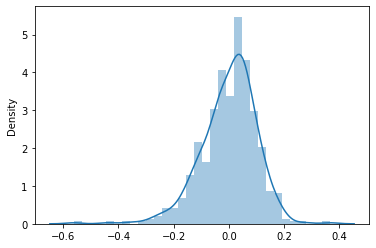

In [102]:
sns.distplot(res)
plt.show()

### Step 5: Prediction and Evaluation on Test set

In [103]:
num_var = ['temp', 'hum', 'windspeed', 'cnt']

In [104]:
# Fit :train
# transform: test
df_test[num_var] = scaler.transform(df_test[num_var])
df_test.head()

,temp,hum,windspeed,cnt,season_spring,season_summer,season_winter,yr_2019,mnth_Aug,mnth_Dec,...,holiday_not holiday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,workingday_yes,weathersit_Cloudy weather with rains,weathersit_Partly cloudy weather
184,0.831783,0.657364,0.084219,0.692706,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
535,0.901354,0.610133,0.153728,0.712034,0,1,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0
299,0.511964,0.837699,0.334206,0.303382,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,1
221,0.881625,0.437098,0.339570,0.547400,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
152,0.817246,0.314298,0.537414,0.569029,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0


In [105]:
y_test = df_test.pop('cnt')
X_test = df_test

In [106]:
X_test_sm = sm.add_constant(X_test)
X_test_sm.head()

,const,temp,hum,windspeed,season_spring,season_summer,season_winter,yr_2019,mnth_Aug,mnth_Dec,...,holiday_not holiday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,workingday_yes,weathersit_Cloudy weather with rains,weathersit_Partly cloudy weather
184,1.0,0.831783,0.657364,0.084219,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
535,1.0,0.901354,0.610133,0.153728,0,1,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0
299,1.0,0.511964,0.837699,0.334206,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,1
221,1.0,0.881625,0.437098,0.339570,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
152,1.0,0.817246,0.314298,0.537414,0,1,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0


In [107]:
drop_vars = ['hum','mnth_Mar','mnth_Oct','weekday_Thursday','mnth_Jun','workingday_yes','weekday_Saturday','weekday_Sunday','mnth_Aug','mnth_May','holiday_not holiday','weekday_Wednesday','temp','mnth_Jul','season_winter']

In [108]:
X_test_sm = X_test_sm.drop(drop_vars, axis=1)

In [114]:
#predict
y_test_pred = lr_model.predict(X_test_sm)

In [117]:
# On test set
r2_score(y_true=y_test , y_pred=y_test_pred)

0.7964419431633134

In [118]:
# On train set
r2_score(y_true=y_train , y_pred=y_train_pred)

0.7997216041527848

There is not much difference in training and test set r2 score , which is good


We can see that the equation of our best fitted line is:

$ cnt = 0.5946 \times constant -0.1875  \times  windspeed - 0.1946  \times  season_spring - 0.0417 \times season_summer + 0.2458 \times yr_2019 -0.1337 \times mnth_Dec -0.1066 \times mnth_Feb -0.1705 \times mnth_Jan -0.1199 \times mnth_Nov + 0.0524 \times mnth_Sep -0.0304 \times weekday_Monday -0.0329 \times weekday_Tuesday -0.3142 \times weathersit_Cloudy weather with rains -0.0859 \times weathersit_Partly cloudy weather $


Overall we have a decent model, which performed well on both trainning and test set.